In [14]:
from itertools import cycle, islice
import json
from pathlib import Path
import typing as tp

import matplotlib.pyplot as plt
import numpy as np

In [17]:
OUTPUT = Path("./outputs")
PATIENCE = 10
EPOCHS = 50

ARCHITECTURES = ("CNN", "LSTM", "GRU")
OPTIMIZERS = ("SGD", "RMSprop", "Adam", "AdaMax")
LEARNING_RATES = (0.001, 0.01, 0.1)
DROPOUT_RATES = (0.0, 0.1, 0.2, 0.3, 0.4, 0.5)

COLORS = ("red", "blue", "green", "orange", "purple", "black")
MARKERS = (".", "1", "+", "*", "2", "x")

In [7]:
def extract_tf_data(report_json: Path, history_json: Path):
    with open(report_json) as handle:
        report = json.load(handle)
    with open(history_json) as handle:
        history = json.load(handle)
    return report, history


def extract_pt_data(report_json: Path, reports_path: Path):
    with open(report_json) as handle:
        report = json.load(handle)

    hist = []
    for p in sorted(reports_path.iterdir(), key=lambda p: int(p.stem)):
        with open(p) as handle:
            hist.append(json.load(handle))

    history = {k : [] for k in report.keys()}
    for h in hist:
        for k in report.keys():
            history[k].append(h[k])

    return report, history

In [57]:
def find_best_val_accuracy(o: str, l: float, d: float, arch: tp.Literal["RNN", "LSTM", "GRU"]) -> float:
    p = OUTPUT / o / str(l) / str(d) / arch
    if arch in ("CNN",):
        try:
            report_json = next(p.rglob("report.json"))
            history_json = next(p.rglob("history.json"))
        except StopIteration:
            raise FileNotFoundError()
        ts_report, vl_reports = extract_tf_data(report_json, history_json)
        epochs = len(next(vl_reports.values()))
    elif arch in ("RNN", "LSTM", "GRU"):
        try:
            report_json = next(p.rglob("report.json"))
        except StopIteration:
            raise FileNotFoundError()
        reports_path = next(p.rglob("reports"))
        ts_report, vl_reports = extract_pt_data(report_json, reports_path)
        epochs = sum(1 for _ in reports_path.iterdir())
    b = epochs - PATIENCE if epochs != EPOCHS else EPOCHS
    vl_report = {k : v[b - 1] for k, v in vl_reports.items()}
    return vl_report["accuracy"]


def plot_best_vl_accuracy(arch: tp.Literal["RNN", "LSTM", "GRU"]):
    for i, o in enumerate(OPTIMIZERS):
        for j, l in enumerate(LEARNING_RATES):
            x = []
            y = []
            for k, d in enumerate(DROPOUT_RATES):
                try:
                    a = find_best_val_accuracy(o, l, d, arch)
                except FileNotFoundError:
                    continue
                x.append(d)
                y.append(a)
            plt.scatter(x=x, y=y, color=COLORS[j], marker=MARKERS[j], label=l)
        plt.title(f"{o} Optimizer")
        plt.xlabel("Dropout Rate")
        plt.ylabel("Best Validation Accuracy")
        plt.legend(title="Learning Rate")
        plt.show()
        plt.savefig(f"graphs/{arch}_{o}.png", dpi=400)
        plt.close()

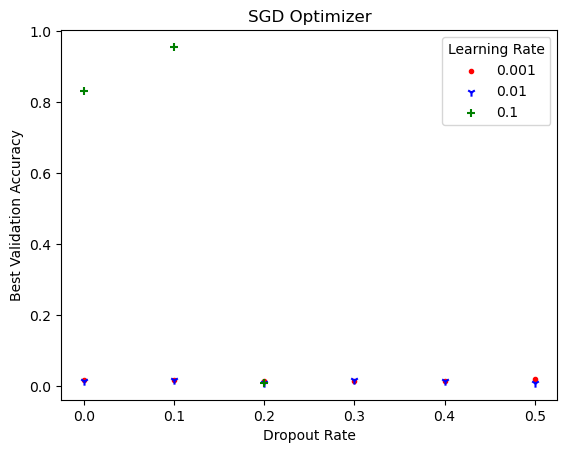

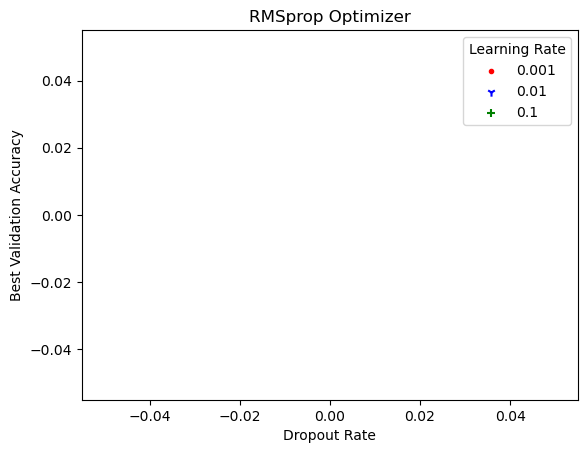

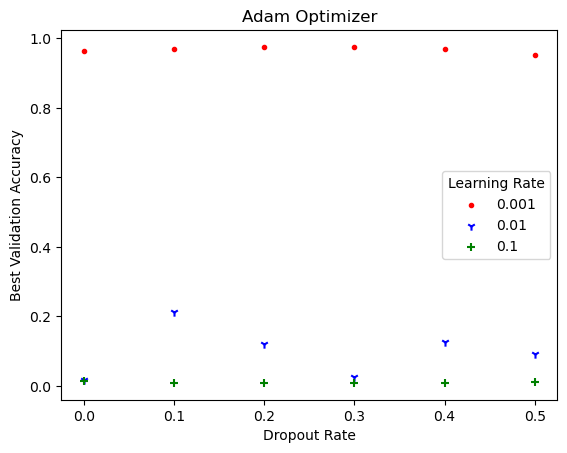

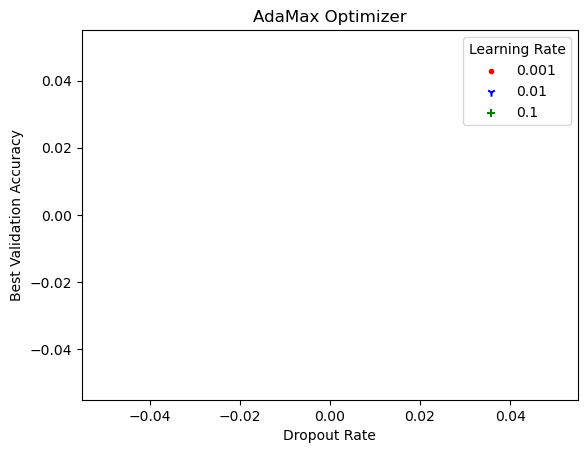

In [58]:
plot_best_vl_accuracy("GRU")